In [54]:
import matplotlib.pyplot as plt
from skimage import io
import numpy as np
import pydicom
from scipy.ndimage import rotate

%matplotlib notebook
plt.rcParams['figure.figsize'] = (16.0, 12.0)

## Make the notebook use full width of display
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Loading data


In [5]:
lungs = io.imread("lungs.jpg", as_gray=True)
print(lungs.shape)

(569, 600)


# Window/Level

Remember, this is just a way to change how we are visualising the data, it doesn't transform the data itself

1.0 0.0


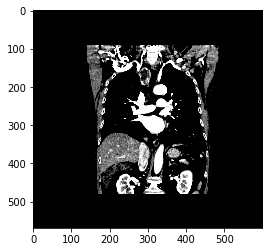

In [12]:
print(lungs.max(), lungs.min())

## Map HU to this range: 
## -1024 = 0
##  3000 = 1
## range = 4024

## From yesterdays practical, you should have figured out what bits of the 0-1 scale correspond to what structures


level = 2000/4024
window = 1000/4024

vis_min = level - window/2
vis_max = level + window/2

plt.imshow(lungs, cmap='Greys_r', vmin=vis_min, vmax=vis_max)

plt.show()



# Threshold

You can use a threshold as a simple segmentation method

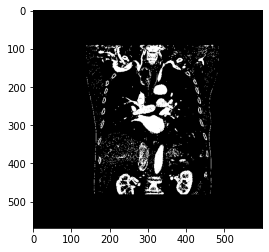

In [19]:
threshold_seg = np.zeros_like(lungs)
threshold_seg[lungs > 2000/4024] = 1 ## This is a one-sided threshold
threshold_seg[lungs < 2300/4024] = 0 ## this makes it a 'top-hat' threshold

## Try tuning this so that only muscle is selected

plt.imshow(threshold_seg, cmap='Greys_r')
plt.show()

# Interpolators

Lets take the lungs image and rotate it through 720 degrees in 10 degree steps. this ought to show how bad the interpolators are

Note, mode is about how the interpolatoe handles the edges, order is about how good the interpolation is, roughly:
 0 = nearest
 1 = linear
 2+ = polynomial
 
It refers to the order of the spline used in interpolation

NB this cell will take a while to run!

try playing with the number of degrees per step. How bad can you make it?

<IPython.core.display.Javascript object>


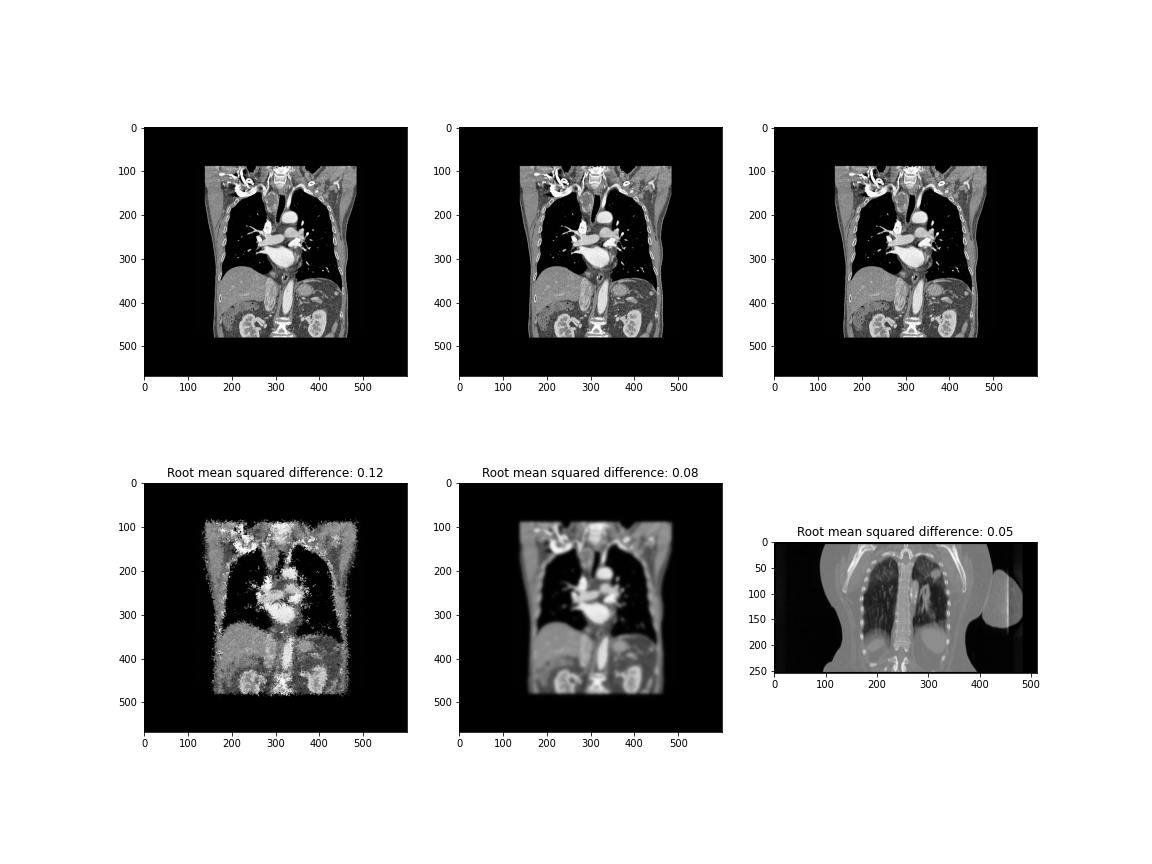

0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,

In [55]:
fig = plt.figure()

ax0 = fig.add_subplot(231)
ax1 = fig.add_subplot(232)
ax2 = fig.add_subplot(233)

ax0.imshow(lungs, cmap='Greys_r')
ax1.imshow(lungs, cmap='Greys_r')
ax2.imshow(lungs, cmap='Greys_r')

lungs_nn = lungs.copy()
lungs_lin = lungs.copy()
lungs_poly = lungs.copy()

ax20 = fig.add_subplot(234)
ax21 = fig.add_subplot(235)
ax22 = fig.add_subplot(236)

l_nn_show = ax20.imshow(lungs_nn, cmap='Greys_r')
ax20.set_title(f"Root mean squared difference: {np.sqrt(np.mean((lungs_nn - lungs)**2)):.2f}")

l_lin_show = ax21.imshow(lungs_lin, cmap='Greys_r')
ax21.set_title(f"Root mean squared difference: {np.sqrt(np.mean((lungs_lin - lungs)**2)):.2f}")
l_poly_show = ax22.imshow(lungs_poly, cmap='Greys_r')
ax22.set_title(f"Root mean squared difference: {np.sqrt(np.mean((lungs_poly - lungs)**2)):.2f}")
plt.show()   

degrees = 10
for i in range(72):
    print(f"{i},",end='')
    lungs_nn = rotate(lungs_nn, degrees, mode='nearest', order=0, reshape=False)
    lungs_lin = rotate(lungs_lin, degrees, mode='nearest', order=1, reshape=False)
    lungs_poly = rotate(lungs_poly, degrees, mode='nearest', order=2, reshape=False)
    
    l_nn_show.set_data(lungs_nn)
    ax20.set_title(f"Root mean squared difference: {np.sqrt(np.mean((lungs_nn - lungs)**2)):.2f}")
    l_lin_show.set_data(lungs_lin)
    ax21.set_title(f"Root mean squared difference: {np.sqrt(np.mean((lungs_lin - lungs)**2)):.2f}")

    l_poly_show.set_data(lungs_poly)
    ax22.set_title(f"Root mean squared difference: {np.sqrt(np.mean((lungs_poly - lungs)**2)):.2f}")

    fig.canvas.draw()
    
    







# DICOM

Earlier in the notebook, I imported the pydicom module, lets now use it and see how it works

In [58]:
## There should be a file called 
patientImage = pydicom.read_file("IMG-0004-00001.dcm")

# print(patientImage)


plt.imshow(patientImage.pixel_array, cmap='Greys_r')
plt.show()
